In [1]:
import numpy as np
from rectipy import Network, random_connectivity
from scipy.stats import cauchy
import matplotlib.pyplot as plt
%matplotlib inline

# change to False, if you are not using dark mode
dark_mode = True

# adapts matplotlib color settings to work with dark mode
if dark_mode:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white' 
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['legend.facecolor'] = 'black'

def lorentzian(n: int, eta: float, delta: float, lb: float, ub: float):
    samples = np.zeros((n,))
    for i in range(n):
        s = cauchy.rvs(loc=eta, scale=delta)
        while s <= lb or s >= ub:
            s = cauchy.rvs(loc=eta, scale=delta)
        samples[i] = s
    return samples


In [2]:
# initialize a network instance 
dt = 1e-2
sr = 100
v_reset = -1e2
v_cutoff = 1e2
ik = Network(dt=dt, device="cpu")

# define IK neurons
N = 500
node = "neuron_model_templates.spiking_neurons.ik.ik"
Delta_v = 0.2
v_t = -40.0
v_r = -60.0
v_thetas = lorentzian(N, eta=v_t, delta=Delta_v, lb=v_r, ub=2 * v_t - v_r)
ik_params={"C": 100.0, "k": 0.7, "v_r": v_r, "v_theta": v_thetas, "b": -2.0, "g": 15.0,
           "tau_u": 33.33, "kappa": 10.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}

# define network connectivity
p = 0.2
W = random_connectivity(N, N, p, normalize=True)

# add population of coupled IK neurons to the network
ik.add_diffeq_node("ik", node, weights=W, source_var="s", target_var="s_in", 
                   input_var="I_ext", output_var="s", spike_var="spike", 
                   spike_def="v", op="ik_op", spike_reset=v_reset,
                   spike_threshold=v_cutoff, node_vars=ik_params
                  )

# save initial state for resetting
y0 = ik.state

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


Text(0.5, 0, 'time')

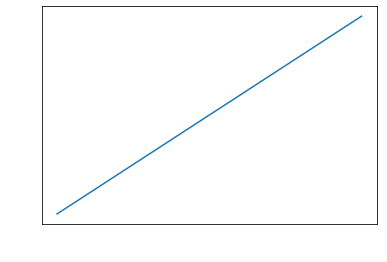

In [3]:
# define extrinsic input
steps = 100000
time = np.arange(0, steps) * dt
inp = np.zeros((steps, N))
in_neurons = np.arange(0, N)
I_ext = np.linspace(30, 60, steps)
for idx in in_neurons:
    inp[:, idx] = I_ext 

# visualize input
plt.plot(inp[:, 0])
plt.ylabel("I_ext")
plt.xlabel("time")

In [4]:
ik.reset(y0)
obs = ik.run(inputs=inp, sampling_steps=sr, verbose=False)

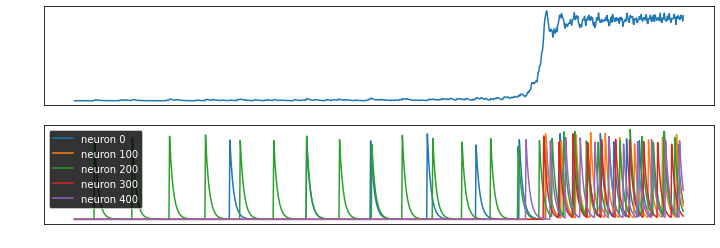

In [5]:
_, axes = plt.subplots(nrows=2, figsize=(12, 4))

# plot average spiking activity
v = obs.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(s)")

# plot spiking activity of example neurons
examples = np.arange(0, N, 100)
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("s")
ax.legend()

In [114]:
obs2 = ik.run(inputs=inp[::-1].copy(), sampling_steps=sr, verbose=False)

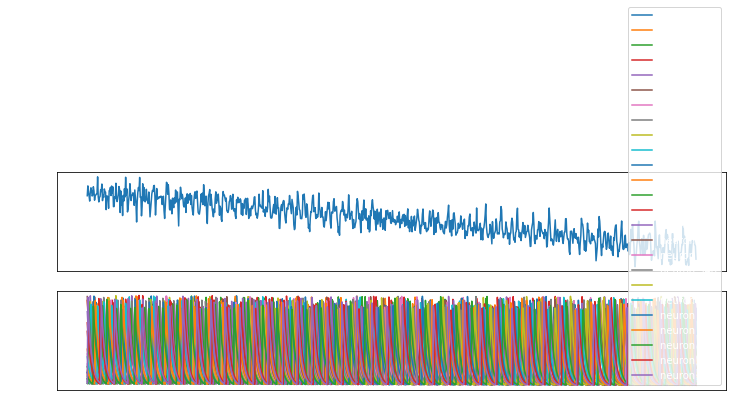

In [115]:
_, axes = plt.subplots(nrows=2, figsize=(12, 4))

# plot average spiking activity
v = obs2.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(s)")

# plot spiking activity of example neurons
examples = np.arange(0, N, 100)
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("s")
ax.legend()

In [116]:
ik.set_var("ik", "ik_op/kappa", 150.0)

In [117]:
ik.reset(y0)
obs3 = ik.run(inputs=inp, sampling_steps=sr, verbose=False)

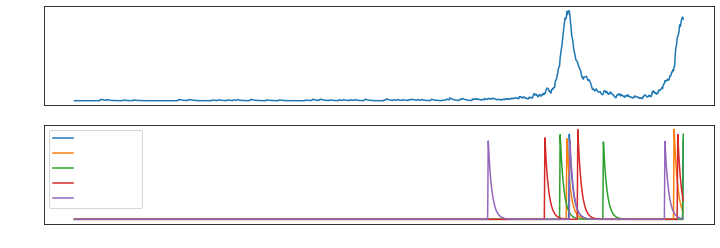

In [118]:
_, axes = plt.subplots(nrows=2, figsize=(12, 4))

# plot average spiking activity
v = obs3.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(s)")

# plot spiking activity of example neurons
examples = np.arange(0, N, 100)
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("s")
ax.legend()

In [119]:
ik.reset(y0)
obs4 = ik.run(inputs=np.zeros((steps, 1)) + 55.0, sampling_steps=sr, verbose=False)

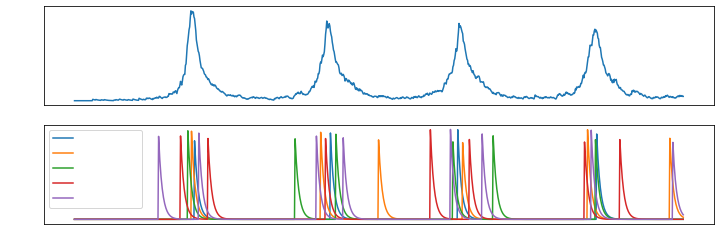

In [120]:
_, axes = plt.subplots(nrows=2, figsize=(12, 4))

# plot average spiking activity
v = obs4.to_dataframe("out")
ax = axes[0]
ax.plot(v.mean(axis=1))
ax.set_ylabel("mean(s)")

# plot spiking activity of example neurons
examples = np.arange(0, N, 100)
ax = axes[1]
for ex in examples:
    ax.plot(v.iloc[:, ex], label=f"neuron {ex}")
ax.set_ylabel("s")
ax.legend()

In [128]:
from pyrates import CircuitTemplate

# define mean-field model
ik_mf = CircuitTemplate.from_yaml("model_templates.neural_mass_models.ik.ik_theta")
mf_params = {"C": 100.0, "k": 0.7, "v_r": v_r, "v_theta": v_t, "b": -2.0, "g": 15.0,
             "a": 0.03, "d": 100.0, "tau_s": 6.0, "E_r": 0.0, "eta": 0.0}
ik_mf.update_var(node_vars={f"p/ik_theta_op/{key}": val for key, val in mf_params.items()})

# set simulation parameters
inp_mf = np.zeros((steps,)) + 55.0

# perform mean-field simulation
res = ik_mf.run(simulation_time=steps*dt,step_size=dt, sampling_step_size=dt*sr, 
                inputs={"p/ik_theta_op/I_ext": inp_mf}, outputs={"s": "p/ik_theta_op/s"}
               )

C:\Users\rgf3807\.conda\envs\ds\lib\site-packages\pyrates-1.0.0-py3.9.egg\pyrates\frontend\template\circuit.py:275: PyRatesWarning: Variable v_theta has not been found on operator ik_theta_op of node p.
  warn(PyRatesWarning(f'Variable {var} has not been found on operator {op} of node {node[0]}.'))


Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 2.349479500000598s.


Text(0, 0.5, 's')

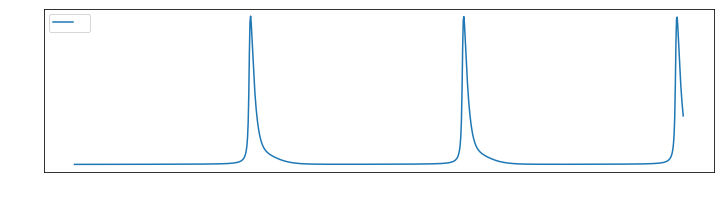

In [131]:
_, ax = plt.subplots(figsize=(12, 3))
res.plot(ax=ax)
ax.set_xlabel("time")
ax.set_ylabel("s")